In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import callbacks as cb
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import warnings
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

Using TensorFlow backend.


In [54]:
df = pd.read_excel('data/protva_t_p_q_2003-2015_FOR_LSTM.xlsx', index_col='date')
print(df.columns)
df = df.iloc[:,[1,3,5,6]]
df.head()

Index(['27509t', '27509p', '27606t', '27606p', '27611t', '27611p', 'Qt'], dtype='object')


,27509p,27606p,27611p,Qt
date,,,,
2003-01-01,1.1,2.0,1.1,9.03
2003-01-02,0.0,0.0,0.0,9.03
2003-01-03,0.8,0.8,0.6,9.20
2003-01-04,0.9,0.9,0.3,9.20
2003-01-05,1.1,0.4,0.4,9.37


In [55]:
# define train/test split
test_size = len(df) - 952
# test_size = len(df[df.index.year < 2013])
print('Train: ', test_size)
print('Test: ', len(df) - test_size)
dataset = df.values
data_mean = dataset[:test_size].mean(axis=0)
data_std = dataset[:test_size].std(axis=0)
print(np.round(data_mean, 3), np.round(data_std, 2))
dataset = (dataset-data_mean)/data_std

Train:  3796
Test:  952
[ 1.955  1.953  1.897 23.548] [ 4.6   4.67  4.39 36.99]


In [56]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

In [61]:
### lookback parameters
past_history = 60 # how many instances a model sees for training, in compliance with other models' input
future_target = 7 # how many instances form a prediction step
STEP = 1 # step size - 1 for daily data
BATCH_SIZE = 30 # how many steps form a batch
BUFFER_SIZE = 1000 # how many batches to shuffle in 
EVALUATION_INTERVAL = len(dataset)/BATCH_SIZE # what data model sees for training
EPOCHS = 100 # how many times a model sees the data

# shaping training and test dataset to chunks
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 3], len(dataset) - test_size,
                                                 None, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 3],
                                             0, 952, past_history,
                                             future_target, STEP)
print('\n Input training data shape:')
print(x_train_multi.shape, y_train_multi.shape)
print('\n Single step history:')
print(x_train_multi[0])
print('\n Single step target:')
print(y_train_multi[0])

# create train and test data from chunks
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

# training and test data shuffling
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print(train_data_multi)


 Input training data shape:
(3729, 60, 4) (3729, 7)

 Single step history:
[[-0.42463993 -0.41777582 -0.43176976 -0.35000892]
 [-0.42463993 -0.41777582 -0.43176976 -0.35000892]
 [-0.42463993 -0.41777582 -0.43176976 -0.35541515]
 [-0.42463993 -0.41777582 -0.43176976 -0.35811827]
 [-0.22910925 -0.41777582 -0.43176976 -0.36352451]
 [-0.42463993 -0.41777582 -0.43176976 -0.36352451]
 [-0.42463993 -0.41777582 -0.43176976 -0.36352451]
 [-0.42463993 -0.41777582 -0.43176976 -0.36352451]
 [-0.42463993 -0.41777582 -0.43176976 -0.36082139]
 [ 0.03159832 -0.41777582 -0.15863377 -0.36082139]
 [-0.33773741 -0.41777582 -0.43176976 -0.35541515]
 [-0.33773741 -0.41777582 -0.36348577 -0.35541515]
 [-0.27256052 -0.03267246  2.82310077 -0.34189956]
 [ 0.24885463  0.24545774 -0.04482711 -0.33919645]
 [-0.42463993 -0.41777582 -0.20415644 -0.33919645]
 [-0.42463993 -0.41777582 -0.43176976 -0.33919645]
 [-0.42463993 -0.41777582 -0.43176976 -0.33649333]
 [-0.42463993 -0.41777582 -0.43176976 -0.33649333]
 [-0.4

In [62]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(50,
                                          return_sequences=False,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(7))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

model_callbacks = [cb.EarlyStopping(patience=10), 
                          cb.ModelCheckpoint(filepath=f"results/LSTM_P.h5", save_best_only=True)]

In [63]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10, callbacks=model_callbacks)

Epoch 1/100
159/158 [==============================] - 5s 31ms/step - loss: 0.2082 - val_loss: 0.1796
Epoch 2/100
159/158 [==============================] - 4s 28ms/step - loss: 0.1779 - val_loss: 0.1593
Epoch 3/100
159/158 [==============================] - 4s 27ms/step - loss: 0.1643 - val_loss: 0.1562
Epoch 4/100
159/158 [==============================] - 4s 27ms/step - loss: 0.1533 - val_loss: 0.1525
Epoch 5/100
159/158 [==============================] - 4s 27ms/step - loss: 0.1464 - val_loss: 0.1456
Epoch 6/100
159/158 [==============================] - 4s 27ms/step - loss: 0.1527 - val_loss: 0.1424
Epoch 7/100
159/158 [==============================] - 4s 28ms/step - loss: 0.1359 - val_loss: 0.1451
Epoch 8/100
159/158 [==============================] - 4s 27ms/step - loss: 0.1390 - val_loss: 0.1370
Epoch 9/100
159/158 [==============================] - 4s 27ms/step - loss: 0.1303 - val_loss: 0.1405
Epoch 10/100
159/158 [==============================] - 4s 26ms/step - loss: 0.137

In [ ]:
# load trained model for time saving
# multi_step_model = load_model(f"results/LSTM_P.h5")

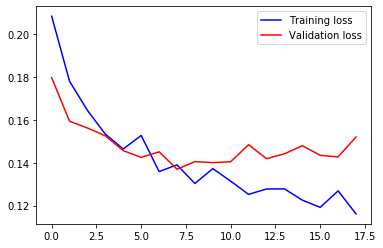

In [64]:
loss = multi_step_history.history['loss']
val_loss = multi_step_history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.show()

Prediction step : 1
8.388
0.936


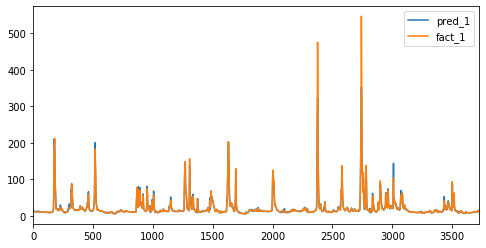

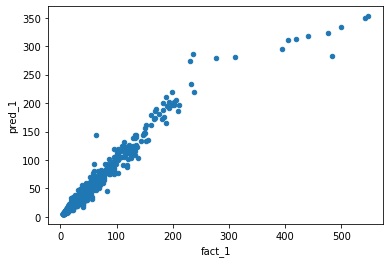

Prediction step : 2
10.147
0.907


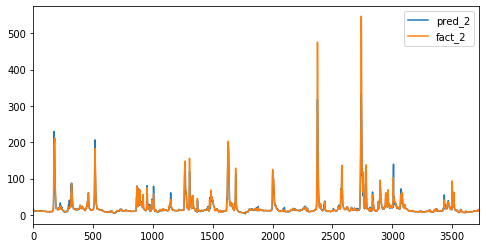

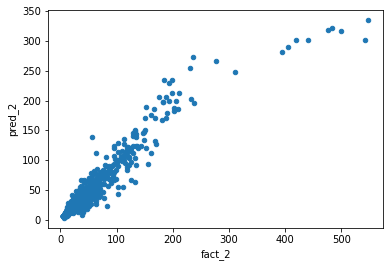

Prediction step : 3
12.659
0.855


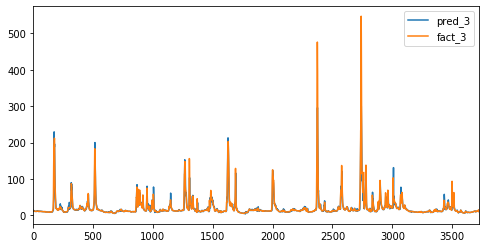

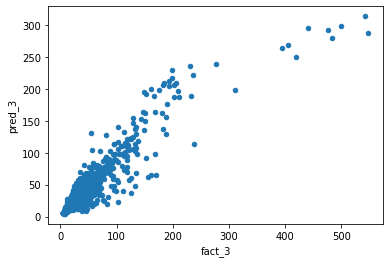

Prediction step : 4
15.426
0.784


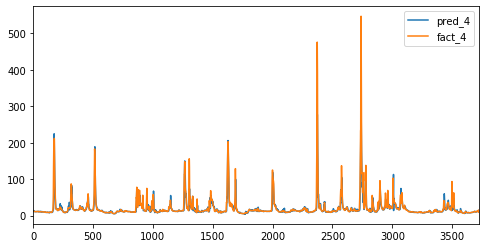

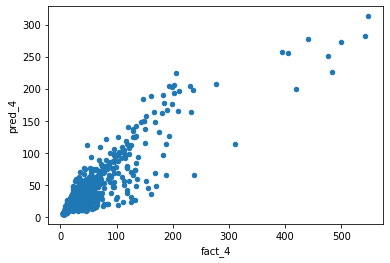

Prediction step : 5
18.842
0.678


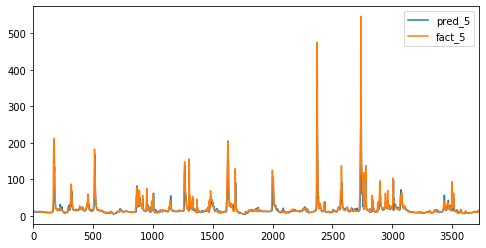

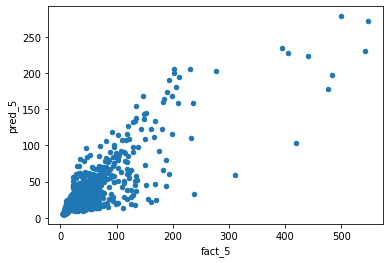

Prediction step : 6
21.732
0.572


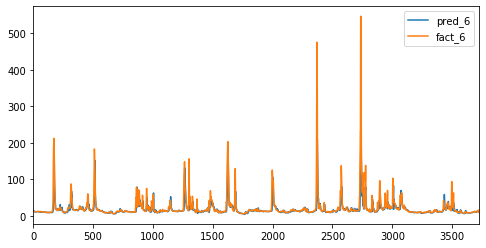

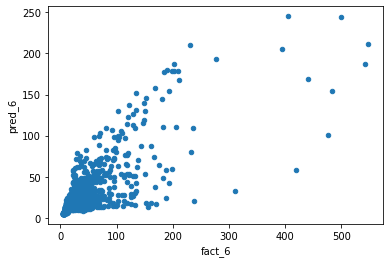

Prediction step : 7
24.868
0.44


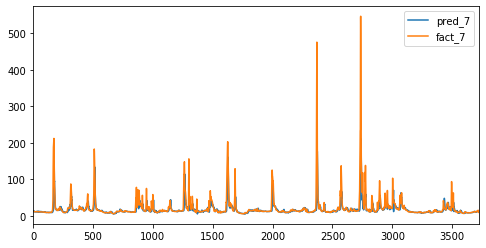

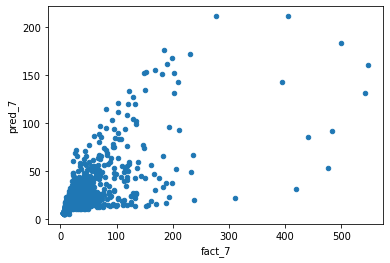

In [73]:
res_df_train = pd.DataFrame()
# compare train data and prediction
for i in range(y_train_multi.shape[1]):
    print('Prediction step :', i + 1)
    train_df = pd.DataFrame(data={'pred_' + str(i+1): multi_step_model.predict(x_train_multi)[:,i], 
                                  'fact_' + str(i+1): y_train_multi[:,i]})
    train_df = train_df * data_std[3] + data_mean[3]
    res_df_train = pd.concat([res_df_train, train_df], sort=False, axis=1)
    print(round(mean_squared_error(train_df['fact_' + str(i+1)], train_df['pred_' + str(i+1)]), 3))
    print(round(r2_score(train_df['fact_' + str(i+1)], train_df['pred_' + str(i+1)]), 3))
    train_df.plot(figsize=(8,4))
    train_df.plot(x='fact_' + str(i+1), y='pred_' + str(i+1), kind='scatter')
    plt.show()
res_df_train.to_excel('results/LSTM_P_train.xlsx')

Prediction step : 1
5.43
0.979


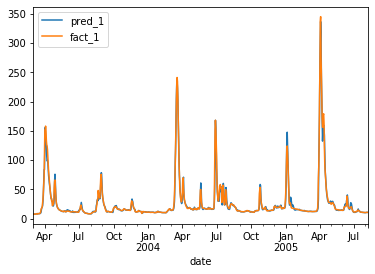

Prediction step : 2
10.361
0.923


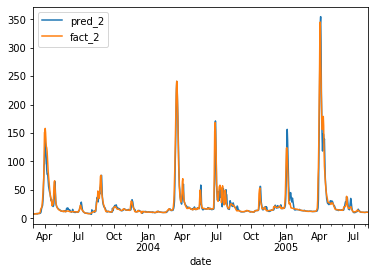

Prediction step : 3
16.293
0.809


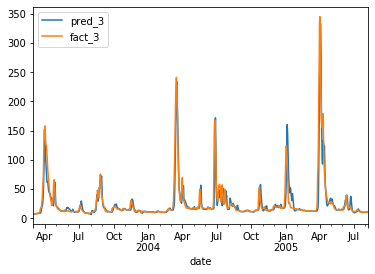

Prediction step : 4
21.435
0.67


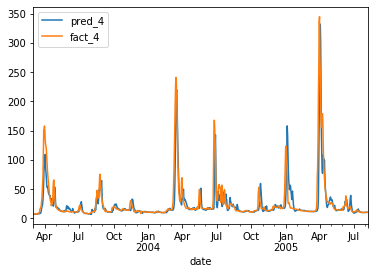

Prediction step : 5
26.147
0.509


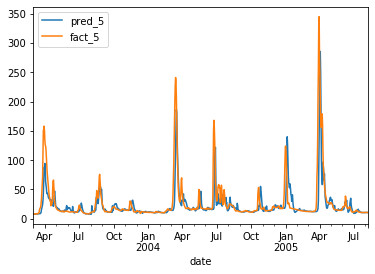

Prediction step : 6
29.697
0.367


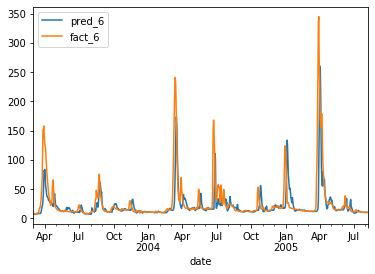

Prediction step : 7
32.44
0.244


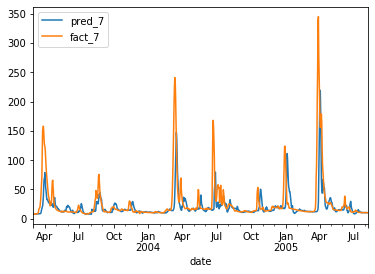

In [74]:
res_df_test = pd.DataFrame()
# compare test data and prediction
for i in range(y_val_multi.shape[1]):
    print('Prediction step :', i + 1)
    val_df = pd.DataFrame(data={'pred_' + str(i+1): multi_step_model.predict(x_val_multi)[:,i], 
                                'fact_' + str(i+1): y_val_multi[:,i]})
    val_df.index = df[past_history-1:(len(df)-test_size-1)].index
    val_df = val_df * data_std[3] + data_mean[3]
    res_df_test = pd.concat([res_df_test, val_df], sort=False, axis=1)
    print(round(mean_squared_error(val_df['fact_' + str(i+1)], val_df['pred_' + str(i+1)]), 3))
    print(round(r2_score(val_df['fact_' + str(i+1)], val_df['pred_' + str(i+1)]), 3))
    val_df.plot()
    plt.show()
res_df_test.to_excel('results/LSTM_P_test.xlsx')